![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Compute total monthly precipitation and evapotranspiration for the relevant basins

In [1]:
import os
import geopandas as gpd
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from common.config import read_config

In [2]:
conf=read_config()
datadir=conf["dataroot"]

In [3]:
basinsgpkg=os.path.join(datadir,'hydroshed_csl03_gl_l02.gpkg')
gdfbasins=gpd.read_file(basinsgpkg)
gdfbasins.head()

ERROR 1: PROJ: proj_create_from_database: Open of /home/karimis/anaconda3/envs/pysh/share/proj failed


,PFAF_ID,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,ENDO,COAST,ORDER,SORT,name,geometry
0,111,1030000010,0,1030000010,1030000010,0.0,0.0,236343.2,236343.2,0,1,0,1,SETIT,"MULTIPOLYGON (((39.76528 15.42917, 39.75492 15..."
1,112,1030003990,0,1030003990,1030003990,0.0,0.0,519027.5,519027.5,0,1,0,2,GULF OF ADEN/SOMALIA,"MULTIPOLYGON (((40.81528 14.75417, 40.79561 14..."
2,114,1030008100,0,1030008100,1030008100,0.0,0.0,797881.4,797881.4,0,0,1,3,SHEBELLE,"MULTIPOLYGON (((36.74167 4.06667, 36.74131 4.0..."
3,117,1030008110,0,1030008110,1030008110,0.0,0.0,1040194.7,1040194.7,0,1,0,4,RUFIJI,"MULTIPOLYGON (((40.84444 -2.43333, 40.83833 -2..."
4,122,1030011660,0,1030011660,1030011660,0.0,0.0,1378103.3,1378121.1,0,0,1,6,ZAMBEZI,"MULTIPOLYGON (((35.2625 -18.23333, 35.26215 -1..."


In [4]:
p_et=os.path.join(datadir,'p-et.nc')
ds=xr.open_dataset(p_et)
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 252, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-01-01T06:00:00 ... 2022-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 4kB ...
Data variables:
    avg_ie      (valid_time, latitude, longitude) float32 1GB ...
    avg_tprate  (valid_time, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [5]:
ds_flux=ds.where(ds.valid_time>np.datetime64("2002-03-01T06:00:00.000000000"),drop=True)
display(ds_flux) ## Select time period overlapping with GRACE/GRACE-(FO)

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 249, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2022-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    avg_ie      (valid_time, latitude, longitude) float32 1GB -4.279e-07 ... ...
    avg_tprate  (valid_time, latitude, longitude) float32 1GB 4.59e-06 ... 2....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

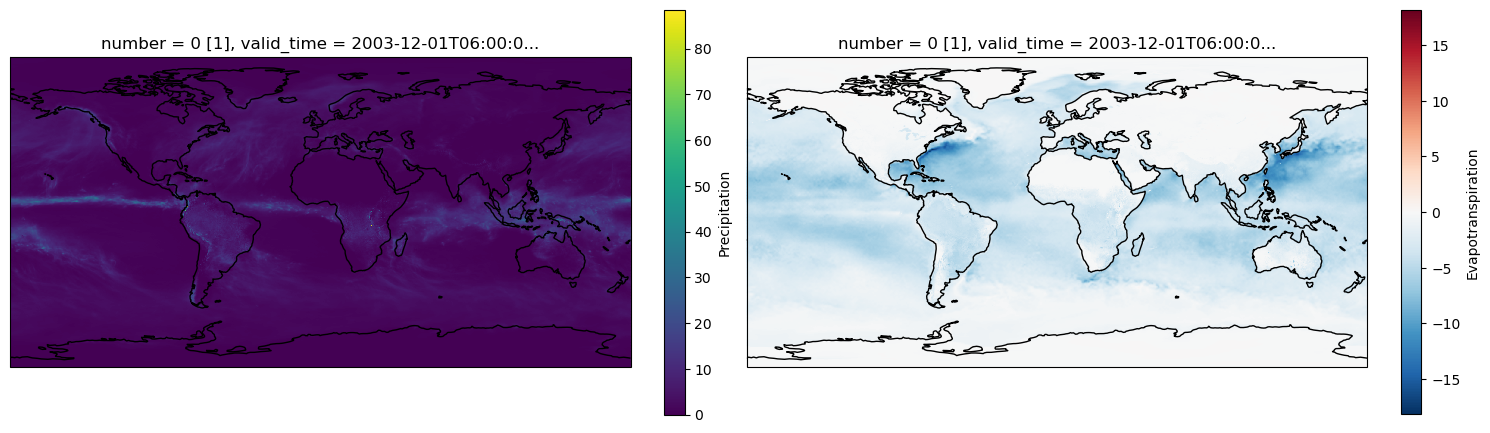

In [6]:
## Visualize precipitation and evapotranspiration in mm per day unit

fig,axs=plt.subplots(ncols=2,nrows=1,figsize=(15,8),subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_scld=ds_flux*(24*3600) # Convert kg m**-2 s**-1 to mm per day

im1=ds_scld.avg_tprate[20].plot(ax=axs[0],add_colorbar=False)
plt.colorbar(im1,fraction=0.03).set_label("Precipitation")
axs[0].coastlines()

im2=ds_scld.avg_ie[20].plot(ax=axs[1],add_colorbar=False)
plt.colorbar(im2,fraction=0.03).set_label("Evapotranspiration")
axs[1].coastlines()
plt.tight_layout()




In [7]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
from shapely.geometry import Point

def era5_polygonmask(basinpolys,dsera5) ->xr.DataArray:
    


    dims=["longitude","latitude","basin"]
    coords={"longitude":dsera5.longitude,"latitude":dsera5.latitude,"basin":basinpolys.name}


    dtmp=xr.DataArray(np.zeros([dsera5.sizes['longitude'],dsera5.sizes['latitude'],len(basinpolys.geometry)]),coords=coords,dims=dims).stack(lonlat=("longitude","latitude"))


    #create a geoDataframe of points from the grid
    ggrd=gpd.GeoDataFrame(geometry=[Point(lon,lat) for lon,lat in dtmp.lonlat.values],crs=4326)
    
    if basinpolys.geometry.crs != ggrd.crs:
        #possibly convert the lon/lat grid in the desired projection before doing the polygon test
        ggrd=ggrd.to_crs(basinpolys.geometry.crs)
    

    #query using a spatial index and set values to 1
    for i,poly in enumerate(basinpolys.geometry): 
        idx=ggrd.sindex.query(poly,predicate="contains")
        dtmp[i,idx]=1.0
    
    
    dtmp=dtmp.unstack("lonlat")
    #logger.info("Applying SH analysis")
    #dsout=dtmp.sh.analysis(nmax,engine=engine) 

    return dtmp

In [8]:
dsmasks=era5_polygonmask(gdfbasins,ds_flux)

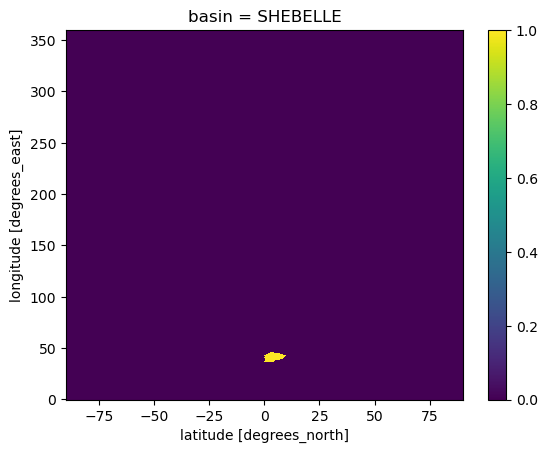

In [9]:
dsmasks.sel(basin="SHEBELLE").plot()

In [10]:
from shxarray.earth.constants import a_earth
dis=np.deg2rad(np.median(np.diff(ds_flux.longitude)))*a_earth
area=dis**2
pxl_wght=np.cos(np.deg2rad(ds_flux.latitude))*area
pxl_wght=xr.DataArray(pxl_wght,dims=["latitude"],coords=dict(latitude=ds_flux.latitude))

In [11]:
ds_flux_wghtd=pxl_wght*ds_flux

In [12]:
import dask.array as da
dsmasks=dsmasks.chunk(chunks={"latitude":180,"longitude":360})
ds_flux_wghtd=ds_flux_wghtd.chunk(chunks={"latitude":180,"longitude":360})

In [13]:
masked_flux=dsmasks*ds_flux_wghtd

In [14]:
basin_flux=masked_flux.sum(dim=("latitude","longitude"))

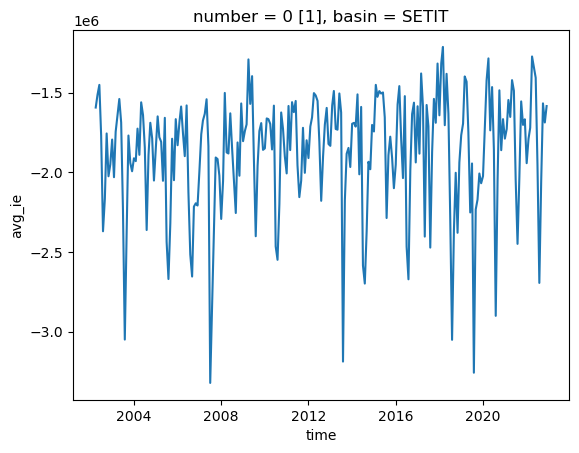

In [18]:
basin_flux.avg_ie.sel(basin="SETIT").plot()

In [16]:
basin_flux['avg_ie'] = basin_flux['avg_ie'].compute()

In [17]:
basin_flux['avg_tprate'] = basin_flux['avg_tprate'].compute()
display(basin_flux)

<xarray.Dataset> Size: 501kB
Dimensions:     (valid_time: 249, basin: 124)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2022-...
    expver      (valid_time) <U4 4kB dask.array<chunksize=(249,), meta=np.ndarray>
  * basin       (basin) object 992B 'SETIT' ... 'TIBETAN PLATEAU'
Data variables:
    avg_ie      (basin, valid_time) float64 247kB -1.593e+06 ... -1.286e+06
    avg_tprate  (basin, valid_time) float64 247kB 3.158e+05 ... 4.258e+05

In [19]:
basin_flux.attrs = ds_flux.attrs
basin_flux = basin_flux.assign_attrs(units="kg s**-1",avg_ie="Time-mean moisture flux",avg_tprate="Time-mean total precipitation rate")
basin_flux

<xarray.Dataset> Size: 501kB
Dimensions:     (valid_time: 249, basin: 124)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2022-...
    expver      (valid_time) <U4 4kB dask.array<chunksize=(249,), meta=np.ndarray>
  * basin       (basin) object 992B 'SETIT' ... 'TIBETAN PLATEAU'
Data variables:
    avg_ie      (basin, valid_time) float64 247kB -1.593e+06 ... -1.286e+06
    avg_tprate  (basin, valid_time) float64 247kB 3.158e+05 ... 4.258e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    units:                   kg s**-1
    avg_ie:                  Time-mean moisture flux
    avg_tprate:              Time-mean total precipitation rate

In [21]:
#save to netcdf for re-use
tp_et_rateout=os.path.join(datadir,conf['ncp-et'])
basin_flux.to_netcdf(tp_et_rateout)

## Compute cumulative monthly precipitation and evapotranspiration (in meters) over a selected basin

In [22]:
N=ds_flux.valid_time.dt.days_in_month #Number of days in month
bas_total_mass=basin_flux*(N*24*3600)

In [23]:
display(bas_total_mass)  # in kg

<xarray.Dataset> Size: 501kB
Dimensions:     (valid_time: 249, basin: 124)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2022-...
    expver      (valid_time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001'
  * basin       (basin) object 992B 'SETIT' ... 'TIBETAN PLATEAU'
Data variables:
    avg_ie      (basin, valid_time) float64 247kB -4.13e+12 ... -3.444e+12
    avg_tprate  (basin, valid_time) float64 247kB 8.185e+11 ... 1.14e+12

In [24]:
total_mass=bas_total_mass.sel(basin="SHEBELLE")

In [25]:
basin_area=gdfbasins.SUB_AREA.loc[gdfbasins.name=="SHEBELLE"].values
basin_area

array([797881.4])

In [26]:
from shxarray.earth.constants import rho_water
water_height=total_mass/(basin_area*(10**6)*rho_water)
display(water_height) # in meters

<xarray.Dataset> Size: 10kB
Dimensions:     (valid_time: 249)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 ... 2022-...
    expver      (valid_time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001'
    basin       <U8 32B 'SHEBELLE'
Data variables:
    avg_ie      (valid_time) float64 2kB -0.06526 -0.06765 ... -0.03597 -0.02348
    avg_tprate  (valid_time) float64 2kB 0.1344 0.04736 ... 0.01992 0.007874

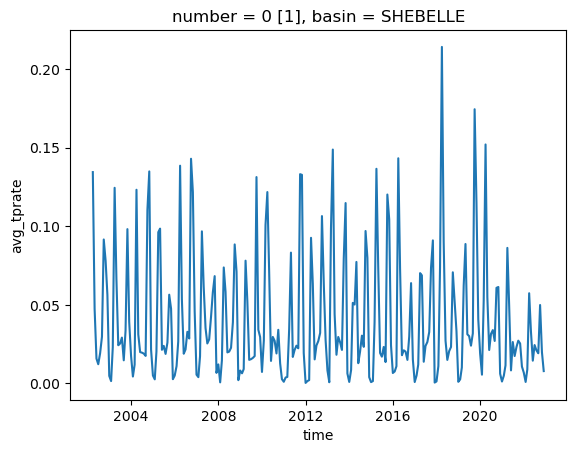

In [27]:
water_height.avg_tprate.plot()

In [28]:
# from scipy import integrate

# time_months=((total_ds_flux_wgthd.valid_time-total_ds_flux_wgthd.valid_time[0]).dt.days)/total_ds_flux_wgthd.valid_time.dt.days_in_month

# cumulative_precip = integrate.cumulative_trapezoid(total_ds_flux_wgthd.avg_tprate, time_months,dx=1.0, axis=1,initial=None)
# cumulative_et = cumulative_trapezoid(total_ds_flux_wgthd.avg_ie, time_months,dx=1.0, axis=1,initial=None)

# init_pnt=np.zeros((cumulative_precip.shape[0],1,cumulative_precip.shape[2]))
# cumulative_precip=np.concatenate([init_pnt,cumulative_precip],axis=1) 
# print(cumulative_precip.shape)

# cumulative_et=np.concatenate([init_pnt,cumulative_et],axis=1) 
# print(cumulative_et.shape)

# total_ds_flux_wgthd["cumulative_precip"]=(("latitude","valid_time","longitude"),cumulative_precip)
# total_ds_flux_wgthd["cumulative_et"]=(("latitude","valid_time","longitude"),cumulative_et)

In [29]:
from scipy import integrate

months=((bas_total_mass.valid_time-bas_total_mass.valid_time[0]).dt.days)/bas_total_mass.valid_time.dt.days_in_month
cumulative_precip=integrate.cumulative_trapezoid(water_height.avg_tprate,months,dx=1.0,axis=0,initial=None)
cumulative_et=integrate.cumulative_trapezoid(water_height.avg_ie,months,dx=1.0,axis=0,initial=None)
cumulative_precip.shape

(248,)

In [30]:
init_pnt=np.zeros(1)
cumulative_precip=np.concatenate([init_pnt,cumulative_precip],axis=0) 
cumulative_et=np.concatenate([init_pnt,cumulative_et],axis=0) 

In [31]:
water_height["cumulative_precip"]=("valid_time",cumulative_precip)
water_height["cumulative_et"]=("valid_time",cumulative_et)

In [32]:
water_height

<xarray.Dataset> Size: 14kB
Dimensions:            (valid_time: 249)
Coordinates:
    number             int64 8B 0
  * valid_time         (valid_time) datetime64[ns] 2kB 2002-04-01T06:00:00 .....
    expver             (valid_time) <U4 4kB '0001' '0001' ... '0001' '0001'
    basin              <U8 32B 'SHEBELLE'
Data variables:
    avg_ie             (valid_time) float64 2kB -0.06526 -0.06765 ... -0.02348
    avg_tprate         (valid_time) float64 2kB 0.1344 0.04736 ... 0.007874
    cumulative_precip  (valid_time) float64 2kB 0.0 0.08794 ... 7.389 7.29
    cumulative_et      (valid_time) float64 2kB 0.0 -0.06431 ... -8.65 -8.439

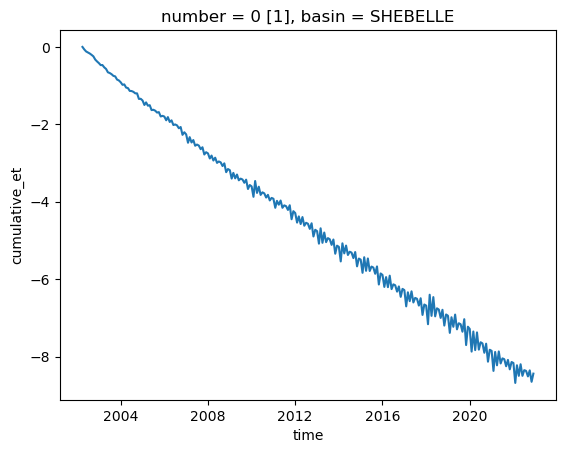

In [33]:
water_height.cumulative_et.plot()

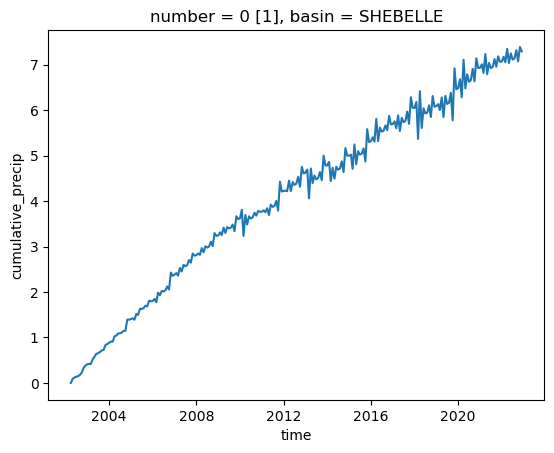

In [34]:
water_height.cumulative_precip.plot()

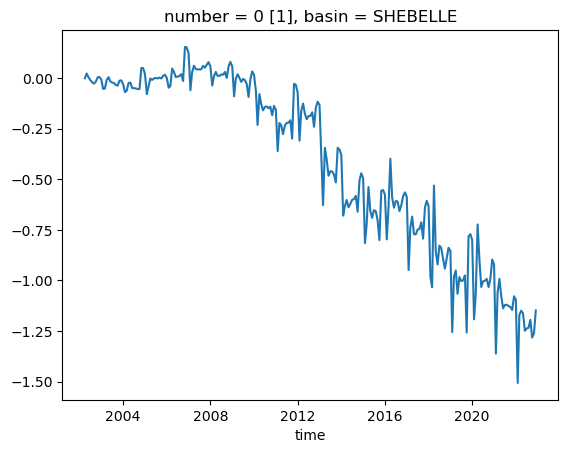

In [35]:
diff=water_height.cumulative_precip+water_height.cumulative_et
diff.plot() # trends?

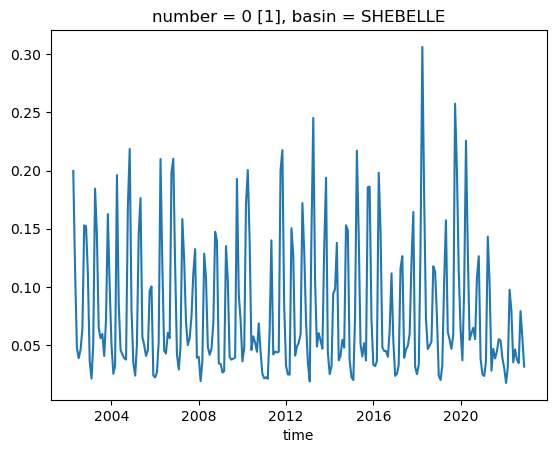

In [36]:
diff=water_height.avg_tprate-water_height.avg_ie
diff.plot() # seasonal variations?